## Plots for experiments in finite regime

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
import scipy
from src import utils
import copy
import pickle

### Plotting setup

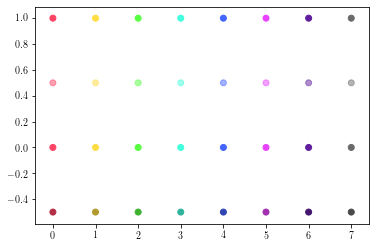

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

### Load and process data

In [3]:
# Code to load (and possibly merge) results from several files, as experiments can be submitted to Euler in different jobs to reduce time

def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i].copy()
    else:
        raise Exception("Cannot merge")
    return old

def load_results(filenames):
    cases, results = load_experiments(filenames[0])
    for filename in filenames[1::]:
        print("Loading %s" % filename)
        new_cases, new_results = load_experiments(filename)
        cases += new_cases
        for k in range(len(results)):
            results[k] = merge_runs(results[k], new_results[k])
    print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))
    return cases, results

In [4]:
def hamming_distance(A,B,p):
    a = np.zeros(p)
    b = np.zeros(p)
    a[list(A)] = 1
    b[list(B)] = 1
    return scipy.spatial.distance.hamming(a, b)

In [5]:
def generate_trajectories(results, cases):
    runs = len(results[0])
    N = len(results[0][0])
    P = len(results)


    no_ints = np.zeros((len(results), runs, N))
    all_trajectories_ham = {}
    all_type1_errors = {}
    names = []
    for k, policy_runs in enumerate(results):
        name = policy_runs[0][0].policy
        print("Processing results for %s policy" % name, end="")
        names.append(name)
        trajectories_ham = []
        type1_errors = []
        for i,run_results in enumerate(policy_runs):
            no_ints[k, i,:] = list(map(lambda result: len(result.interventions()), run_results))
            for j, result in enumerate(run_results):
                estimates = result.estimates() + [result.estimate]
                trajectory_ham = list(map(lambda estimate: hamming_distance(cases[j].truth, estimate, cases[j].sem.p), estimates))
                type1_error = list(map(lambda estimate: set.issubset(estimate, cases[j].truth), estimates))
                trajectories_ham.append(trajectory_ham)
                type1_errors.append(type1_error)
        all_trajectories_ham[name] = trajectories_ham
        all_type1_errors[name] = type1_errors
        print(" done")
    return all_trajectories_ham, all_type1_errors, N, P, runs, names, no_ints

In [6]:
# Experiments to load

experiments = [
["experiments/results_1587961452_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:10_alpha:0.0005_tag:apr25sl.pickle"],
["experiments/results_1587881500_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:100_alpha:0.0005_tag:apr25sl.pickle"],
["experiments/results_1587913432_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:1000_alpha:0.0005_tag:apr25sl.pickle"],
["experiments/results_1587936821_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:10_alpha:0.0025_tag:apr25sm.pickle"],
["experiments/results_1587872472_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:100_alpha:0.0025_tag:apr25sm.pickle"],
["experiments/results_1587908944_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:1000_alpha:0.0025_tag:apr25sm.pickle"],
["experiments/results_1587931361_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:10_alpha:0.005_tag:apr25sh.pickle"],
["experiments/results_1587874267_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:100_alpha:0.005_tag:apr25sh.pickle"],
["experiments/results_1588089424_k:3.0_G:500_runs:8_n_min:12_n_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_i_mean:10_i_var:1_random_state:0_finite:True_max_iter:50_n:1000_alpha:0.005_tag:apr25sh.pickle"],
]

In [7]:
def process_experiments(experiments):
    Trajectories = []
    Type1Errors = []
    NoInts = []

    for i,filenames in enumerate(experiments):
        print("\n\n %d/%d" % (i+1, len(experiments)), end=" ")
        cases, results = load_results(filenames)
        trajectories, type1_errors, N, P, runs, names, no_ints = generate_trajectories(results, cases)
        if i==0:
            prev_N, prev_P, prev_runs = N, P, runs
        elif prev_N != N or prev_P != P or prev_runs != runs:
            print(N, P, runs)
            print(prev_N, prev_P, prev_runs)
            print("Experiments have different number of graphs / policies / runs")
        Trajectories.append(trajectories)
        Type1Errors.append(type1_errors)
        NoInts.append(no_ints)
    return Trajectories, Type1Errors, NoInts, N, P, runs, names, cases

In [8]:
Trajectories, Type1Errors, NoInts, N, P, runs, names, cases = process_experiments(experiments)



 1/9 
Loaded a total of 500 graphs with 8 runs each
Processing results for random policy done
Processing results for e policy done
Processing results for r policy done
Processing results for e + r policy done
Processing results for markov policy done
Processing results for markov + e policy done
Processing results for markov + r policy done
Processing results for markov + e + r policy done


 2/9 
Loaded a total of 500 graphs with 8 runs each
Processing results for random policy done
Processing results for e policy done
Processing results for r policy done
Processing results for e + r policy done
Processing results for markov policy done
Processing results for markov + e policy done
Processing results for markov + r policy done
Processing results for markov + e + r policy done


 3/9 
Loaded a total of 500 graphs with 8 runs each
Processing results for random policy done
Processing results for e policy done
Processing results for r policy done
Processing results for e + r policy done

**Summary of graphs used**

500 graphs in total


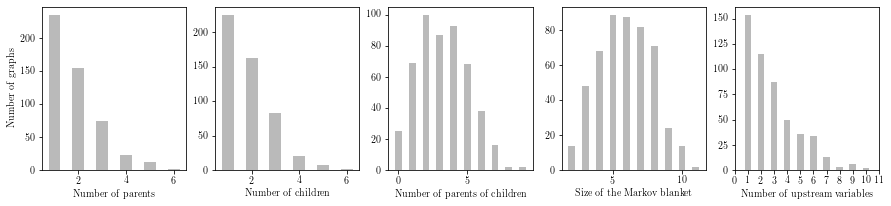

In [9]:
n_parents = np.zeros(N)
n_children = np.zeros(N)
n_poc = np.zeros(N)
n_upstream = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    parents, children, poc, mb = utils.graph_info(case.target, case.sem.W)
    ancestors = utils.ancestors(case.target, case.sem.W)
    n_parents[i] = len(parents)
    n_children[i] = len(children)
    n_poc[i] = len(poc)
    n_upstream[i] = len(ancestors)
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(15,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(151), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(152), plot_hist(n_children, "Number of children")
plt.subplot(153), plot_hist(n_poc, "Number of parents of children")
plt.subplot(154), plot_hist(size_mb, "Size of the Markov blanket")
plt.subplot(155), plot_hist(n_upstream, "Number of upstream variables")
ax = plt.gca()
ax.set_xticks(range(12))

print("%d graphs in total" % N)

In [10]:
max_iter = 50

### Plot B: Comparing effects of sample size

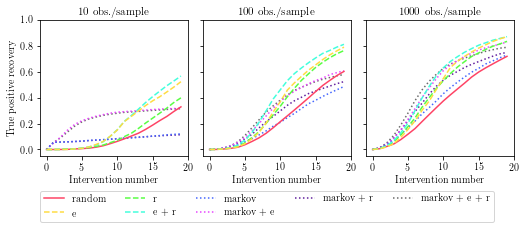

In [11]:
# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.2)
plt.figure(figsize=(8.5,2.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]

##############################
# Plot trajectories for n=10
hm_dist10 = np.zeros((P, N*runs, max_iter+1))
for i, trajectories in enumerate(Trajectories[0].values()):
    for j, trajectory in enumerate(trajectories):
        hm_dist10[i, j, 0:len(trajectory)] = trajectory
mean10 = np.mean(hm_dist10[:, :, :] ==0, axis=1)

plt.subplot(gs[0])
ax = plt.gca()
zorder = [1,4,2,3,-1,-2,-3,-4]
for i,name in enumerate(names):
    ax.plot(x_axis, mean10[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
plt.ylabel("True positive recovery")
ax.set_xticks(np.arange(0, plot_iter+1, 5))
ax.text(0.5,1.04,"10 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=100
hm_dist100 = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[1].items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist100[i, j, 0:len(trajectory)] = trajectory
mean100 = np.mean(hm_dist100[:, :, :] == 0, axis=1)
plt.subplot(gs[1])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean100[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 5))
ax.text(0.5,1.04,"100 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=1000
hm_dist1000 = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[2].items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist1000[i, j, 0:len(trajectory)] = trajectory
mean1000 = np.mean(hm_dist1000[:, :, :] == 0, axis=1)

plt.subplot(gs[2])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean1000[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 5))
ax.text(0.5,1.04,"1000 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/tpr_finite.pdf', bbox_inches='tight')

### Plot C: Sensitivity analysis

For the next two plots (sensitivity and type-1 error) the levels on the plot have to be adjusted manually, to correspond to the `alpha` parameter from the experiments which were loaded.

In [12]:
levels = [0.025, 0.125, 0.25]

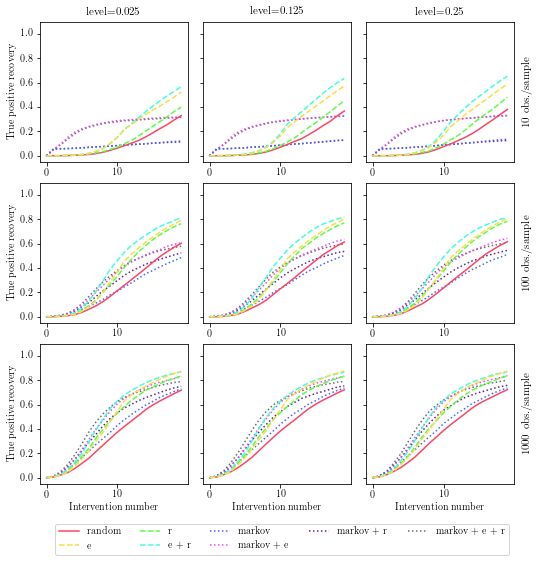

In [13]:
# Plot settings
gs = gridspec.GridSpec(3, 3, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,8.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1.1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]

plots = zip([Trajectories[i] for i in [0,3,6,1,4,7,2,5,8]],
            levels * 3,
            [10] * 3 + [100] * 3 + [1000] * 3)

##############################
# Plot trajectories for n=10
for i, (all_trajectories, level, sample_size) in enumerate(plots):
    plt.subplot(gs[i])
    ax = plt.gca()
    print("Plotting %d/%d" % (i+1, len(Trajectories)), end="\r")
    hm_dist = np.zeros((P, N*runs, max_iter+1))
    for j, policy_trajectories in enumerate(all_trajectories.values()):
        for k, trajectory in enumerate(policy_trajectories):
            n = min(plot_iter, len(trajectory))
            hm_dist[j, k, 0:n] = trajectory[0:n]
    mean = np.mean(hm_dist == 0, axis=1)
    # Plot TPR for each policy
    for j,name in enumerate(names):
        ax.plot(x_axis, mean[j,x_axis], label=name, linewidth=1.5, linestyle = linestyle[j], color=colors[j], zorder=zorder[j])    
    # Labels / legend
    if i < 3:
        ax.text(0.5,1.05,"level=%s" % level, transform=ax.transAxes, fontsize=11, ha="center")
    if i % 3 == 2:
        ax.text(1.05,0.5,"%d obs./sample" % sample_size, transform=ax.transAxes, fontsize=11, va="center", rotation=90)
    ax.set_yticklabels([]) if i % 3 != 0 else None
    plt.ylim(ylim)
    plt.ylabel("True positive recovery") if i % 3 == 0 else None
    plt.xlabel("Intervention number") if i >= 6 else None
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(1, -.25))
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

### Plot D: Type-1 error rate

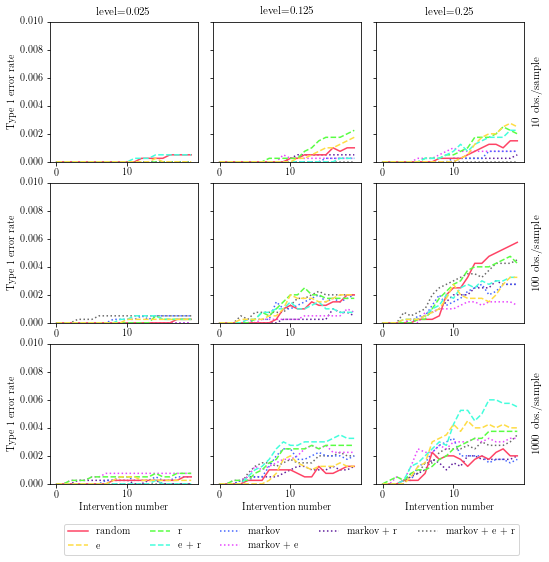

In [14]:
# Plot settings
gs = gridspec.GridSpec(3, 3, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,8.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]

plots = zip([Type1Errors[i] for i in [0,3,6,1,4,7,2,5,8]],
            levels * 3,
            [10] * 3 + [100] * 3 + [1000] * 3)

##############################
# Plot trajectories for n=10
for i, (all_error_trajectories, level, sample_size) in enumerate(plots):
    plt.subplot(gs[i])
    ax = plt.gca()
    print("Plotting %d/%d" % (i+1, len(Type1Errors)), end="\r")
    errors = np.ones((P, N*runs, max_iter+1))
    for j, policy_trajectories in enumerate(all_error_trajectories.values()):
        for k, trajectory in enumerate(policy_trajectories):
            n = min(plot_iter, len(trajectory))
            errors[j, k, 0:n] = trajectory[0:n]
    mean = np.mean(1 - errors, axis=1)
    # Plot TPR for each policy
    for j,name in enumerate(names):
        ax.plot(x_axis, mean[j,x_axis], label=name, linewidth=1.5, linestyle = linestyle[j], color=colors[j], zorder=zorder[j])    
    # Labels / legend
    if i < 3:
        ax.text(0.5,1.05,"level=%s" % level, transform=ax.transAxes, fontsize=11, ha="center")
    if i % 3 == 2:
        ax.text(1.05,0.5,"%d obs./sample" % sample_size, transform=ax.transAxes, fontsize=11, va="center", rotation=90)
    ax.set_yticklabels([]) if i % 3 != 0 else None
    plt.ylim([0, 0.01])
    plt.ylabel("Type 1 error rate") if i % 3 == 0 else None
    plt.xlabel("Intervention number") if i >= 6 else None
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(1, -.25))
plt.savefig('figures/type1error.pdf', bbox_inches='tight')

## For 50 iterations

### Plots E: Number of interventions required for 50 iterations

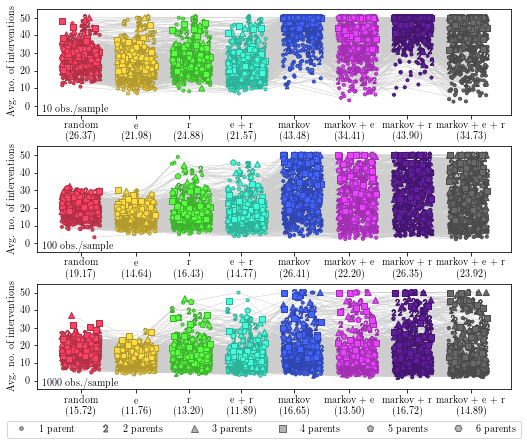

In [15]:
# Plotting parameters

gs = gridspec.GridSpec(3, 1, wspace=0.10, hspace=0.3)
plt.figure(figsize=(8.5,7))
dev = 0.35
xaxis = np.tile(np.arange(P), (N, 1)) - np.outer(np.linspace(-dev, dev, N), np.ones(P))
ecolor = "#cdcdcd"
markers = [".", "$2$", "^", "s", "p", "H"]

#-----------------------------------
# Function for individual (n=x) plot

def point_plot(NoInts, ax, parents = None):
    # Plotting
    means = NoInts.mean(axis=1)
    no_parents = np.array(list(map(lambda case: len(case.truth), cases)))
    parents = range(no_parents.min(), no_parents.max() + 1) if parents is None else parents
    for p in parents:
        idx = idx = np.where(no_parents == p)[0]
        # Plot lines first
        for i in idx:            
            plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5)
        # Plot dots
        for i in idx:
            plt.scatter(xaxis[i,:], means[:, i].T, marker=markers[p-1], c=colors[0:P], zorder=1, edgecolors=colorsb)
    
    # Set labels 
    plt.ylabel("Avg. no. of interventions")
    ax.set_xticks([0,1,1.95,2.9,3.85,4.85,5.9,7.05])
    total_averages = means.mean(axis=1)
    labels = []
    for i, avg in enumerate(total_averages):
        labels.append(names[i] + "\n(%0.2f)" % avg)
    ax.set_xticklabels(labels, ha="center", rotation=0)
    

#---------------------------
# Compose all plots together

NoIntsAux = copy.deepcopy(NoInts)
for no_ints in NoIntsAux:
    no_ints[no_ints > max_iter] = max_iter

parents = None

# n=10
plt.subplot(gs[0])
ax = plt.gca()
point_plot(NoIntsAux[0], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"10 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# n=100
plt.subplot(gs[1])
ax = plt.gca()
point_plot(NoIntsAux[1], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"100 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# n=1000
plt.subplot(gs[2])
ax = plt.gca()
point_plot(NoIntsAux[2], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"1000 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# Build legend
legend_elements = []
for i,m in enumerate(markers):
    legend_elements.append(Line2D([0],[0],
                                  marker=m,
                                  color=[0,0,0,0],
                                  label= '%d parent' % (i+1) + ('s' if i > 0 else ''),
                                  markerfacecolor=colorsa[7],
                                  markeredgecolor=colors[7],
                                  markersize=7))
ax.legend(handles=legend_elements,prop=fontP, ncol=6, bbox_to_anchor=(1.03, -0.25))

# Save figure
plt.savefig('figures/intervention_numbers_finite_50_iter.pdf', bbox_inches='tight')

### Plot F: Comparing effects of sample size for 50 iterations

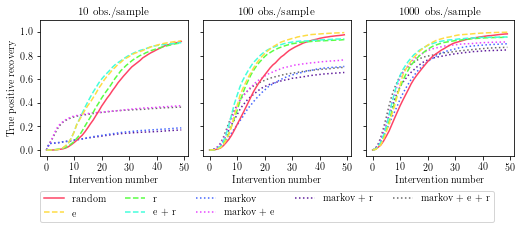

In [16]:
# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.2)
plt.figure(figsize=(8.5,2.5))

plot_iter = 50
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1.1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]

##############################
# Plot trajectories for n=10
hm_dist10 = np.zeros((P, N*runs, max_iter+1))
for i, trajectories in enumerate(Trajectories[0].values()):
    for j, trajectory in enumerate(trajectories):
        hm_dist10[i, j, 0:len(trajectory)] = trajectory
mean10 = np.mean(hm_dist10[:, :, :] ==0, axis=1)

plt.subplot(gs[0])
ax = plt.gca()
zorder = [1,4,2,3,-1,-2,-3,-4]
for i,name in enumerate(names):
    ax.plot(x_axis, mean10[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
plt.ylabel("True positive recovery")
ax.set_xticks(np.arange(0, plot_iter+1, 10))
ax.text(0.5,1.04,"10 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=100
hm_dist100 = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[1].items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist100[i, j, 0:len(trajectory)] = trajectory
mean100 = np.mean(hm_dist100[:, :, :] == 0, axis=1)
plt.subplot(gs[1])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean100[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 10))
ax.text(0.5,1.04,"100 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=1000
hm_dist1000 = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[2].items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist1000[i, j, 0:len(trajectory)] = trajectory
mean1000 = np.mean(hm_dist1000[:, :, :] == 0, axis=1)

plt.subplot(gs[2])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean1000[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 10))
ax.text(0.5,1.04,"1000 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/tpr_finite_50_iter.pdf', bbox_inches='tight')